## Imports  

In [64]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 
import torch
import pandas as pd
from datasets import Dataset, DatasetDict
import seaborn as sns    
from sklearn import model_selection

In [65]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_tensor="pt")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

id2label = {0: "CONTROL", 1: "BROCA"}
label2id = {"CONTROL": 0, "BROCA": 1}

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
dataset_filename = "../../preprocessing/data/processed_merge.csv"
data = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [68]:
data

,scenario,source_file,original_text,preprocessed_text,label
0,Window,UMD24.cha,"+"" I was just practicing . 714781_715861",i was just practicing.,0
1,Umbrella,wright01a.cha,"+"" I'll be okay . 2117418_2117778",i will be okay.,0
2,Cinderella,73-2.cha,Cinderella &-um &-um two . 697729_703189,cinderella two.,1
3,BNT,adler13a.cha,yes ‡ &=laughs <I know> [/] I know . 1725952_...,yes i know i know.,1
4,Cat,17-1.cha,&-um but somehow the fireman came . 606241_61...,but somehow the fireman came.,0
...,...,...,...,...,...
56950,Umbrella,wright70a.cha,"+"" I don't need an umbrella . 655566_656686",i do not need an umbrella.,0
56951,Flood,scale07a.cha,+< &+y yes no yes no yeah &=points:picture . [...,yes no yes no yeah.,1
56952,Important_Event,UNH1051.cha,so ‡ I &-um went to school in Florida . 25995...,so i went to school in florida.,0
56953,Important_Event,18-2.cha,we would have our nice lunch . 495175_496325,we would have our nice lunch.,0


In [69]:
data["label"].value_counts()

label
0    41095
1    15860
Name: count, dtype: int64

In [70]:
dataset = Dataset.from_pandas(data)

In [71]:
dataset

Dataset({
    features: ['scenario', 'source_file', 'original_text', 'preprocessed_text', 'label'],
    num_rows: 56955
})

# Visualize data

In [72]:
import re
sentences = data["preprocessed_text"]
x = pd.Series([len(re.findall("[a-zA-Z_]+", x)) for x in sentences])
data.insert(loc=0, column="lens", value=x)

In [73]:
data.iloc[data["lens"].idxmax()]

lens                                                                77
scenario                                                           Cat
source_file                                                    7-1.cha
original_text        so ‡ &-uh the firefighters arrive only to disc...
preprocessed_text    so the firefighters arrive only to discover th...
label                                                                0
Name: 35262, dtype: object

In [74]:
sentences = data[data['label']==1]
sentences = sentences['preprocessed_text']
lens = [len(re.findall("[a-zA-Z_]+", x)) for x in sentences]

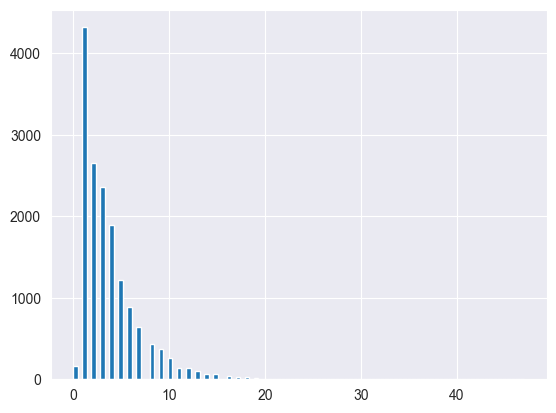

In [75]:
# a lot of aphasic sentences are 1-3 words long
import matplotlib.pyplot as plt
plt.hist(lens,bins=100)
plt.show()

In [76]:
data = data[data['lens'] >= 5]

In [77]:
data

,lens,scenario,source_file,original_text,preprocessed_text,label
3,5,BNT,adler13a.cha,yes ‡ &=laughs <I know> [/] I know . 1725952_...,yes i know i know.,1
4,5,Cat,17-1.cha,&-um but somehow the fireman came . 606241_61...,but somehow the fireman came.,0
5,10,Cinderella,1030-5.cha,and [/] &-um and &-um he [* s:uk] want &+t hæp...,and and he want her lettuce and her tie and.,1
6,17,Window,richardson178.cha,and he was having fun <until one or> [//] unti...,and he was having fun until one or until one t...,0
7,11,Speech,kempler04a.cha,it was because <I can't> [//] &-uh <it was> [/...,it was because i cannot it was i was i i.,1
...,...,...,...,...,...,...
56950,6,Umbrella,wright70a.cha,"+"" I don't need an umbrella . 655566_656686",i do not need an umbrella.,0
56951,5,Flood,scale07a.cha,+< &+y yes no yes no yeah &=points:picture . [...,yes no yes no yeah.,1
56952,7,Important_Event,UNH1051.cha,so ‡ I &-um went to school in Florida . 25995...,so i went to school in florida.,0
56953,6,Important_Event,18-2.cha,we would have our nice lunch . 495175_496325,we would have our nice lunch.,0


In [78]:
data.to_csv("../../preprocessing/data/processed_merge_new.csv")

In [79]:
data["label"].value_counts()

label
0    33855
1     4469
Name: count, dtype: int64

In [80]:
33855/4469

7.57552025061535

In [81]:
def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    print(metric_res)
    return metric_res

In [82]:
def preprocess_function(examples):
    return tokenizer(examples["preprocessed_text"], padding=True, truncation=True, return_tensors="pt")

In [83]:
tokenized_data = dataset.map(preprocess_function, batched=True).with_format("torch")

Map:   0%|          | 0/56955 [00:00<?, ? examples/s]

In [84]:
# 70% train, 30% test + valid
train_testvalid = tokenized_data.train_test_split(test_size=0.2, seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=41)

In [85]:
tokenized_data_split = DatasetDict({
    "train": train_testvalid["train"],
    "test": test_valid["test"],
    "valid": test_valid["train"]})

In [86]:
tokenized_data_split

DatasetDict({
    train: Dataset({
        features: ['scenario', 'source_file', 'original_text', 'preprocessed_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 45564
    })
    test: Dataset({
        features: ['scenario', 'source_file', 'original_text', 'preprocessed_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5696
    })
    valid: Dataset({
        features: ['scenario', 'source_file', 'original_text', 'preprocessed_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5695
    })
})

In [87]:
training_args = TrainingArguments(
    output_dir="../models/bert_finetuned",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    use_cpu = False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_split["train"],
    eval_dataset=tokenized_data_split["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model('../models/bert_finetuned')

C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'accuracy': 0.9085162423178227, 'recall': 0.8046924540266328, 'precision': 0.8562753036437247, 'f1': 0.8296829029094476}
{'accuracy': 0.913081650570676, 'recall': 0.8192771084337349, 'precision': 0.8601864181091877, 'f1': 0.8392335173757713}


In [88]:
trainer.evaluate()

{'accuracy': 0.913081650570676, 'recall': 0.8192771084337349, 'precision': 0.8601864181091877, 'f1': 0.8392335173757713}


{'eval_loss': 0.25206202268600464,
 'eval_accuracy': 0.913081650570676,
 'eval_recall': 0.8192771084337349,
 'eval_precision': 0.8601864181091877,
 'eval_f1': 0.8392335173757713,
 'eval_runtime': 13.6373,
 'eval_samples_per_second': 417.604,
 'eval_steps_per_second': 26.105,
 'epoch': 2.0}

# Evaluate model

In [89]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModelForSequenceClassification.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [90]:
sentences = tokenized_data_split["test"]["preprocessed_text"]
true_labels = tokenized_data_split["test"]["label"] 

In [91]:
pred_labels = []

for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device) 
    with torch.no_grad():
        logits = model(inputs).logits
    predicted_class_id = logits.argmax().item()
    pred_labels.append(predicted_class_id)

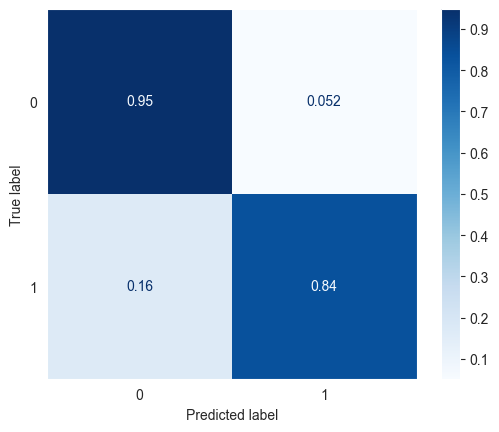

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [93]:
accuracy_score(true_labels, pred_labels)

0.9164325842696629

In [94]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9415857896773625
0.8357187305538271
0.8854992173815313


# Feature visualization

In [95]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModel.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [96]:
def extract_hidden_states(batch):
    sentences = [x for x in batch["preprocessed_text"]]
    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        last_hidden_state = model(inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [97]:
# hidden = tokenized_data_split.map(
#     extract_hidden_states, batched=True)

In [98]:
hidden.save_to_disk('../models/bert_dataset')

NameError: name 'hidden' is not defined

In [ ]:
hidden["test"].column_names

In [ ]:
print(np.array(hidden["train"]["hidden state"]).shape)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X_train = np.array(hidden["train"]["hidden state"])
y_train = np.array(hidden["train"]["label"])

X_test = np.array(hidden["test"]["hidden state"])
y_test = np.array(hidden["test"]["label"])

In [ ]:
# reduce to 2d for visualization
pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_2d1 = pca.fit_transform(x_scaled1)
x_2d1.shape

In [ ]:
# reduce to 3d for visualization
pca = PCA(n_components=3)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_3d = pca.fit_transform(x_scaled)
x_3d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_3d1 = pca.fit_transform(x_scaled1)
x_3d1.shape

In [ ]:
# 2d viz
fig, ax = plt.subplots(2, 2, figsize=(7, 5))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].scatter(x_2d_sub[:, 0], x_2d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label] +" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub1 = x_2d1[y_test == i]
    ax[i+2].scatter(x_2d_sub1[:, 0], x_2d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label] +" TEST" )

plt.tight_layout()
plt.show()

### Shows us that there might be an overlap in control text and broca text which indistinguishable to the model (so model goes with control as sort of default strategy)

In [ ]:
# 3d vis

fig, ax = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(8, 6))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub = x_3d[y_train == i]
    ax[i].scatter(x_3d_sub[:, 0], x_3d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label]+" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub1 = x_3d1[y_test == i]
    ax[i+2].scatter(x_3d_sub1[:, 0], x_3d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label]+" TEST" )

plt.tight_layout()
plt.show()

# Attention viz

In [ ]:
from bertviz import model_view, head_view
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModel.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### For control sentence

In [ ]:
input = tokenizer.encode(sentences[0], return_tensors="pt")
output = model(input, output_attentions=True)

attention = output[-1]
tokens = tokenizer.convert_ids_to_tokens(input[0]) 
model_view(attention, tokens)
print(sentences[0], true_labels[0])

### For broca sentence

In [ ]:
input = tokenizer.encode(sentences[8], return_tensors="pt")
output = model(input, output_attentions=True)

attention = output[-1]
tokens = tokenizer.convert_ids_to_tokens(input[0]) 
model_view(attention, tokens)
print(sentences[8], true_labels[8])